# NVIDIA NIM ： 
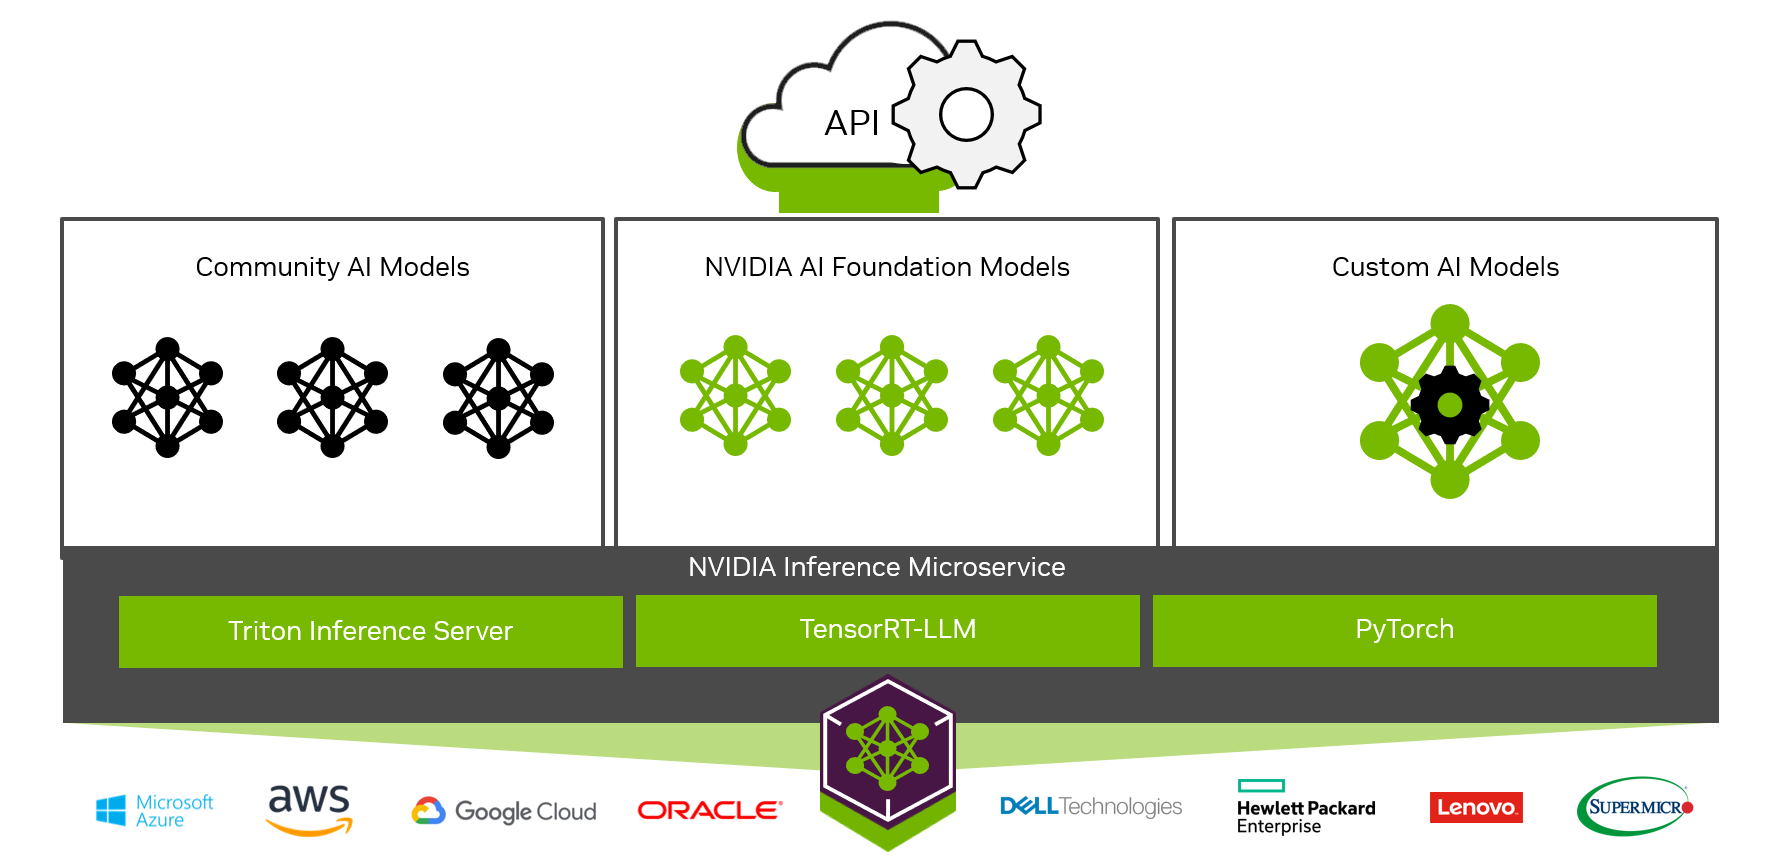

### LLM -RAG

https://python.langchain.com/v0.1/docs/integrations/chat/nvidia_ai_endpoints/#rag-context-models
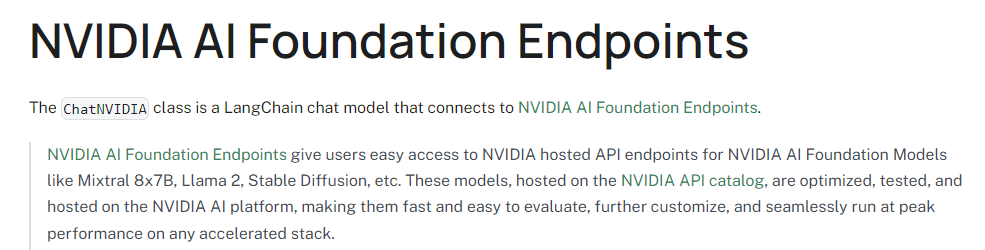

In [1]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings
from langchain.chains import ConversationalRetrievalChain, LLMChain
from langchain.chains.conversational_retrieval.prompts import CONDENSE_QUESTION_PROMPT, QA_PROMPT
from langchain.chains.question_answering import load_qa_chain
from langchain.memory import ConversationBufferMemory
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [2]:
import getpass
import os

if not os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):
    nvapi_key = getpass.getpass("Enter your NVIDIA API key: ")
    assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
    os.environ["NVIDIA_API_KEY"] = nvapi_key

### 定义html_document_loader网络文档数据加载器：进行文档解析返回文档内容

In [18]:
import re
from typing import List, Union

import requests
from bs4 import BeautifulSoup

def html_document_loader(url: Union[str, bytes]) -> str:
    """
    Loads the HTML content of a document from a given URL and return it's content.

    Args:
        url: The URL of the document.

    Returns:
        The content of the document.

    Raises:
        Exception: If there is an error while making the HTTP request.

    """
    try:
        response = requests.get(url)
        html_content = response.text
    except Exception as e:
        print(f"Failed to load {url} due to exception {e}")
        return ""

    try:
        # 创建Beautiful Soup对象用来解析html
        soup = BeautifulSoup(html_content, "html.parser")

        # 删除脚本和样式标签
        for script in soup(["script", "style"]):
            script.extract()

        # 从 HTML 文档中获取纯文本
        text = soup.get_text()

        # 去除空格换行符
        text = re.sub("\s+", " ", text).strip()

        return text
    except Exception as e:
        print(f"Exception {e} while loading document")
        return ""

### 定义数据向量化工具

In [21]:
def create_embeddings(embedding_path: str = "./embed"):

    embedding_path = "./embed"
    print(f"Storing embeddings to {embedding_path}")

    # 包含 NVIDIA NeMo toolkit技术文档的网页列表
    urls = [
         "http://www.alexzhenwu.com/"
    ]

    # 使用html_document_loader对NeMo toolkit技术文档数据进行加载
    documents = []
    for url in urls:
        document = html_document_loader(url)
        documents.append(document)

    #进行chunk分词分块处理
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=0,
        length_function=len,
    )
    texts = text_splitter.create_documents(documents)
    index_docs(url, text_splitter, texts, embedding_path)
    print("Generated embedding successfully")

### 定义index_docs函数作为构建向量储存和文档检索工具

In [5]:
def index_docs(url: Union[str, bytes], splitter, documents: List[str], dest_embed_dir) -> None:
    """
    Split the document into chunks and create embeddings for the document

    Args:
        url: Source url for the document.
        splitter: Splitter used to split the document
        documents: list of documents whose embeddings needs to be created
        dest_embed_dir: destination directory for embeddings

    Returns:
        None
    """
    # 通过NVIDIAEmbeddings工具类调用NIM中的"ai-embed-qa-4"向量化模型
    embeddings = NVIDIAEmbeddings(model="NV-Embed-QA")
    
    for document in documents:
        texts = splitter.split_text(document.page_content)

        # 根据url清洗好的文档内容构建元数据
        metadatas = [document.metadata]

        # 创建embeddings嵌入并通过FAISS进行向量存储
        if os.path.exists(dest_embed_dir):
            update = FAISS.load_local(folder_path=dest_embed_dir, embeddings=embeddings, allow_dangerous_deserialization=True)
            update.add_texts(texts, metadatas=metadatas)
            update.save_local(folder_path=dest_embed_dir)
        else:
            docsearch = FAISS.from_texts(texts, embedding=embeddings, metadatas=metadatas)
            docsearch.save_local(folder_path=dest_embed_dir)

### 使用定义好的相关函数和工具执行文档嵌入Embeddings的生成

In [15]:
create_embeddings()
embedding_model = NVIDIAEmbeddings(model="NV-Embed-QA")

Storing embeddings to ./embed
Generated embedding successfully


In [16]:
# Embed documents
embedding_path = "embed/"
docsearch = FAISS.load_local(folder_path=embedding_path, embeddings=embedding_model, allow_dangerous_deserialization=True)

### langchain结合NIM实现LLM-RAG检索：并对比未使用RAG的llm输出与使用LLM-RAG的输出效果

In [17]:
llm = ChatNVIDIA(model="mistralai/mixtral-8x7b-instruct-v0.1")
result = llm.invoke("who is Zhen Wu")
print(result.content)

吴振是中国知名企业家、海 navigation navigate 商和政策研究家。他是阿里巴巴集团的联合创始人之一，也是中国第一批 self-made 富豪之一。吴振在中国著名的985计划学术项目中就读，后来获得了计算机科学的学位。

在建立阿里巴巴之前，吴振已经在香港工作了几年，并在一家互联网公司担任技术总监。在20年的互联网事业生涯中，吴振发明了许多创新产品和服务，并带领阿里巴巴成为中国最大的互联网企业之一。

除了在企业事业方面的成就，吴振还积极参与公益和社会活动。他多次捐赠大量资金，以支持教育、健康、环保和文化保护等方面的项目。

请随时让我知道，如果你有其他关于吴振的问题需要回答。


In [9]:
llm = ChatNVIDIA(model="ai-mixtral-8x7b-instruct")

memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

question_generator = LLMChain(llm=llm, prompt=CONDENSE_QUESTION_PROMPT)

chat = ChatNVIDIA(model="ai-mixtral-8x7b-instruct", temperature=0.1, max_tokens=1000, top_p=1.0)

doc_chain = load_qa_chain(chat , chain_type="stuff", prompt=QA_PROMPT)

qa = ConversationalRetrievalChain(
    retriever=docsearch.as_retriever(),
    combine_docs_chain=doc_chain,
    memory=memory,
    question_generator=question_generator,
)

/Users/zhenwu/anaconda3/envs/AutoGen/lib/python3.11/site-packages/langchain_nvidia_ai_endpoints/_statics.py:579: UserWarning: Model ai-mixtral-8x7b-instruct is deprecated. Using mistralai/mixtral-8x7b-instruct-v0.1 instead.
  warnings.warn(
/Users/zhenwu/anaconda3/envs/AutoGen/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(
/Users/zhenwu/anaconda3/envs/AutoGen/lib/python3.11/site-packages/langchain_nvidia_ai_endpoints/_statics.py:579: UserWarning: Model ai-mixtral-8x7b-instruct is deprecated. Using mistralai/mixtral-8x7b-instruct-v0.1 instead.
  warnings.warn(
/Users/zhenwu/anaconda3/envs/AutoGen/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `ConversationalRetrievalChain` was deprecated in LangChain 0.1.17 and will be remov

In [10]:
query = "tell me something about Zhen Wu"
result = qa({"question": query})
rag_result = result.get("answer")

/Users/zhenwu/anaconda3/envs/AutoGen/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [11]:
rag_result

'I\'m sorry for any confusion, but the text you\'ve provided doesn\'t seem to contain any information about a place or event called "明日剧场". The text is about various topics related to AI tools, checkpoints, optimizations, and policies from NVIDIA Corporation. Therefore, I don\'t have any helpful information about "明日剧场" to provide.'

* NVIDIA AI Endpoint介绍页面： https://python.langchain.com/v0.1/docs/integrations/chat/nvidia_ai_endpoints/
* NVIDIA NIM页面： https://build.nvidia.com/explore/discover
* NVIDIA DLI课程学习资料页面：https://www.nvidia.cn/training/online/
------------------

![](https://v.png.pub/imgs/2024/06/24/d64b7856c05fa5d4.png)
